In [1]:
from odc.geo.gridspec import GridSpec
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import numpy as np
import xarray as xr
import geopandas as gpd

import datacube
dc = datacube.Datacube()

from dea_tools.spatial import xr_interpolate

### setup gridspec

In [2]:
# Expanded Extents 96 km tiling grid
gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=30,
    tile_shape=(3200, 3200),
    origin=xy_(-4416000, -6912000),
)

In [3]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326", # TODO: Raf, why is this crs different to above c3_bbox? This seems problematic. Please investigate
)
grid_gdf.explore()

In [4]:
# Extract GeoBox for specific tile 
bbox = (45, 58) # x51y54
geobox = gs_c3_expanded[bbox]  
geobox.explore()

### load HAT and SS

In [5]:
# load in file
HAT_gpd = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/HAT_file.gpkg') # TODO: Raf, change this back to original file from Paul B - this has x and y, whereas the modified version has labels of lat long (but they are not)

# Converting HAT file to CRS 3577 to match gridspec
HAT_gpd_EPSG3577 = HAT_gpd.to_crs("EPSG:3577")

In [6]:
# load in file
SS_gpd = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/STF_SS_ElevationClasses.geojson')

# Converting SS file to CRS 3577 to match gridspec
SS_gpd_EPSG3577 = SS_gpd.to_crs("EPSG:3577")

In [7]:
# TODO: Raf, why is this diffferent to previous code?
# example: HAT_SS_gpd = gpd.sjoin(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, predicate='within')
HAT_SS_gpd = gpd.overlay(HAT_gpd_EPSG3577, SS_gpd_EPSG3577, how='intersection')

In [8]:
# creating a new column in mainland_grid and populating with the sum of HAT and Storm Surge
HAT_SS_gpd['HATSS'] = HAT_SS_gpd['HAT'] + HAT_SS_gpd['SSElev']

### load srtm

In [9]:
# Load srtm to geobox
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', resampling="bilinear", like=geobox)
srtm = srtm_ds.dem_h

In [10]:
# elevation
# greater than -6m AHD and less than 11m AHD == True
# some areas in NT are below 0 AHD and need to be included in potential supratidal extent, hence value of -6 that Raf has checked is sensible.
# 11m max elevation now being used (was 10m previously) due to HAT + SS value max of 10.53m
# for connectivity model less than 11m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
AHD_min = -6
AHD_max = 11
lessthan_AHD = srtm <= AHD_max
greaterthan_AHD = srtm >= AHD_min
srtm_mask = lessthan_AHD & greaterthan_AHD

In [11]:
srtm_mask = srtm_mask.squeeze('time').astype('int8')

In [12]:
# get elevation values for srtm_mask
supratidal_elev = srtm * srtm_mask
supratidal_elev = xr.where(supratidal_elev == 0, np.nan, supratidal_elev.values)

### interpolate HAT using srtm bounds

In [13]:
%%time
# interpolate HAT and SS
interpolate_idw = xr_interpolate(ds=srtm, gdf=HAT_SS_gpd, columns=['HAT', 'SSElev'], method="idw")
HAT_interpolate = interpolate_idw.HAT
SS_interpolate = interpolate_idw.SSElev

# add two layers together
HATSS_interpolate = HAT_interpolate + SS_interpolate

CPU times: user 37.7 s, sys: 2.91 s, total: 40.6 s
Wall time: 18.1 s


### generate elevation probability product

In [14]:
# generate elevation probability product
# values of 1 for <= HAT
# values normalised between 1 and 0.5 > HAT and <= HAT_SS
# values normalised between 0.5 and 1 > HAT_SS and <= 10m AHD
HAT = xr.where(supratidal_elev <= HAT_interpolate, 1, np.nan)

In [15]:
# HAT + storm
HAT_storm = xr.where((supratidal_elev > HAT_interpolate) & (supratidal_elev <= HATSS_interpolate), supratidal_elev.values, np.nan)

# normalise between HAT and HAT_SS
# Find the minimum and maximum values in the data array
min_value = HAT_storm.min()
max_value = HAT_storm.max()
# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_norm = (HAT_storm - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_norm_05_1 = (((1 - HAT_storm_norm)/2) + 0.5)

In [16]:
# HAT + storm to 11m
HAT_storm_11AHD = xr.where((supratidal_elev > HATSS_interpolate) & (supratidal_elev <= 11), supratidal_elev.values, np.nan)

# normalise between HAT_SS and 11m AHD
# Find the minimum and maximum values in the data array
min_value = HAT_storm_11AHD.min()
max_value = 11
# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_11AHD_norm = (HAT_storm_11AHD - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_11AHD_norm_05_0 = ((1 - HAT_storm_11AHD_norm)/2)

In [17]:
# combine layers back together
supratidal_combine = ((HAT.fillna(0)) + (HAT_storm_norm_05_1.fillna(0)) + (HAT_storm_11AHD_norm_05_0.fillna(0))).squeeze('time')
# remove outside extent (make np.nan)
supratidal_elevation_model = xr.where(srtm_mask == 1, supratidal_combine.values, np.nan)

PosixPath('supratidal_elevation_model.tif')

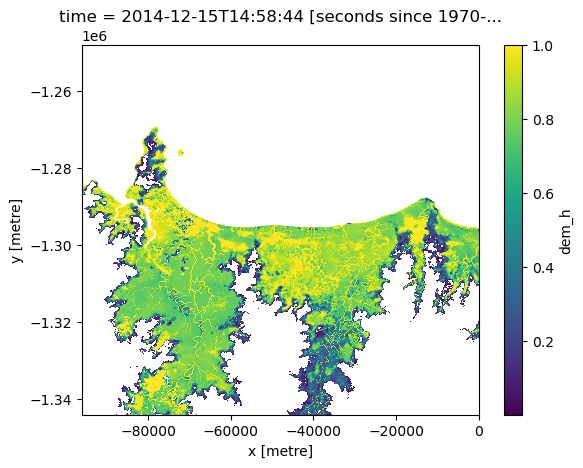

In [18]:
# TODO: Raf, seems there is a problem with some lake areas coming up as values of 1, this was not the case in the previous product. Please rectify
supratidal_elevation_model.plot()
supratidal_elevation_model.odc.write_cog("supratidal_elevation_model.tif", overwrite=True)